In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time

In [2]:
with open('owm-api-key.txt', 'r') as key_file:
    key = key_file.read()

owm = pyowm.OWM(key)

In [9]:
cities = pd.read_csv("cities.csv", ',')
valid_cities = []

In [10]:
for index, row in cities.iterrows():
    lookup = dic.locations_for(row['City'])
    if lookup==[]:
        print(row['City'])
    else:
        valid_cities.append(lookup[0])

Friburg
Wurzburg
Rotthalmuenster
Munchen
Ratisbon
Nurnberg
Klitzschen bei Torga
Frankfurt


D:\Apps\Programs\Anaconda2\lib\site-packages\pyowm\webapi25\cityidregistry.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  'nocase': lambda city_name, toponym: city_name.lower() == toponym.lower(),


Münster
Nekhel
Wadi El Natroon
Dabaa
Sollum
Djerba Mellita
Sfax El-Maou
Enfidha Hammamet
Kelibia
Tinfouye
In Salah
Ain Hadjaj
Rhourd Nouss
Beni Abbes
Hassi-Messaoud
Ghardaia
Hassir'Mel
Elbayadh
Laghoua
Bou-Saada
Khenchella
Alger
Tenes
Nouasseur
Chefchaouen
Makko
Guriat
Turaif
Ma'An
Ghor El Safi
Mafraq
Tel-Aviv
Beyrouth
Lattakia
Hassakah
Kamishli
Erevan
Tbilissi
Zestafoni
Wladikavkaz
Nal'Cik
Kizljar
Majkop
Taipak
Chapaevo
Uralsk
Sorocinsk
Bol'Saja Gluscica
Astrahan
Jaskul
Tihoreck
Primorsko-Ahtarsk
Ganjushkino
Remontnoe
Ejsk
Novyj Ushtogan
Malye Derbety
Kotel'Nikovo
Zaporizhzhia
Verhnij Baskuncak
Nizhny-Chir
Dnipropetrovs'K
Bokovskaja
Izium
Aleksandrov-Gaj
Bogucar
Valujki
Krasnyj Kut
Kalac
Urjupinsk
Belgorod (Ru)
Ersov (Ru)
Oktjabr'Skij Gorodok
Balasov
Bogoroditskoe Fenin
Pugacev
Rtiscevo
Zerdevka
Ai-Petri
Chornomors'Ke
Odesa
Kryvyi Rih
Liubashivka
Mohyliv-Podilskyi
Vinnytsia
Khmel'Nytskyi
Volodymyr-Volynskyi
Homiel
Mozyr
Sarlyk
Bugul'Ma
Celno-Versiny
Musljumovo
Vjatskie Poljany
Ekateri

In [11]:
valid_cities

[<pyowm.webapi25.location.Location - id=2924585, name=Friedrichshafen, lon=9.48333, lat=47.650002>,
 <pyowm.webapi25.location.Location - id=2825297, name=Stuttgart, lon=9.17702, lat=48.782318>,
 <pyowm.webapi25.location.Location - id=2853969, name=Pforzheim, lon=8.7, lat=48.883331>,
 <pyowm.webapi25.location.Location - id=2939797, name=Crailsheim, lon=10.07193, lat=49.134441>,
 <pyowm.webapi25.location.Location - id=2820256, name=Ulm, lon=9.99155, lat=48.398411>,
 <pyowm.webapi25.location.Location - id=2871992, name=Memmingen, lon=10.18527, lat=47.983719>,
 <pyowm.webapi25.location.Location - id=2954172, name=Augsburg, lon=10.88333, lat=48.366669>,
 <pyowm.webapi25.location.Location - id=2951825, name=Bayreuth, lon=11.57833, lat=49.948059>,
 <pyowm.webapi25.location.Location - id=2803560, name=Zwickau, lon=12.5, lat=50.73333>,
 <pyowm.webapi25.location.Location - id=2940132, name=Chemnitz, lon=12.91667, lat=50.833328>,
 <pyowm.webapi25.location.Location - id=2879139, name=Leipzig, lon=

In [12]:
lon = []
lat = []
for city in valid_cities:
    lon.append(city.get_lon())
    lat.append(city.get_lat())

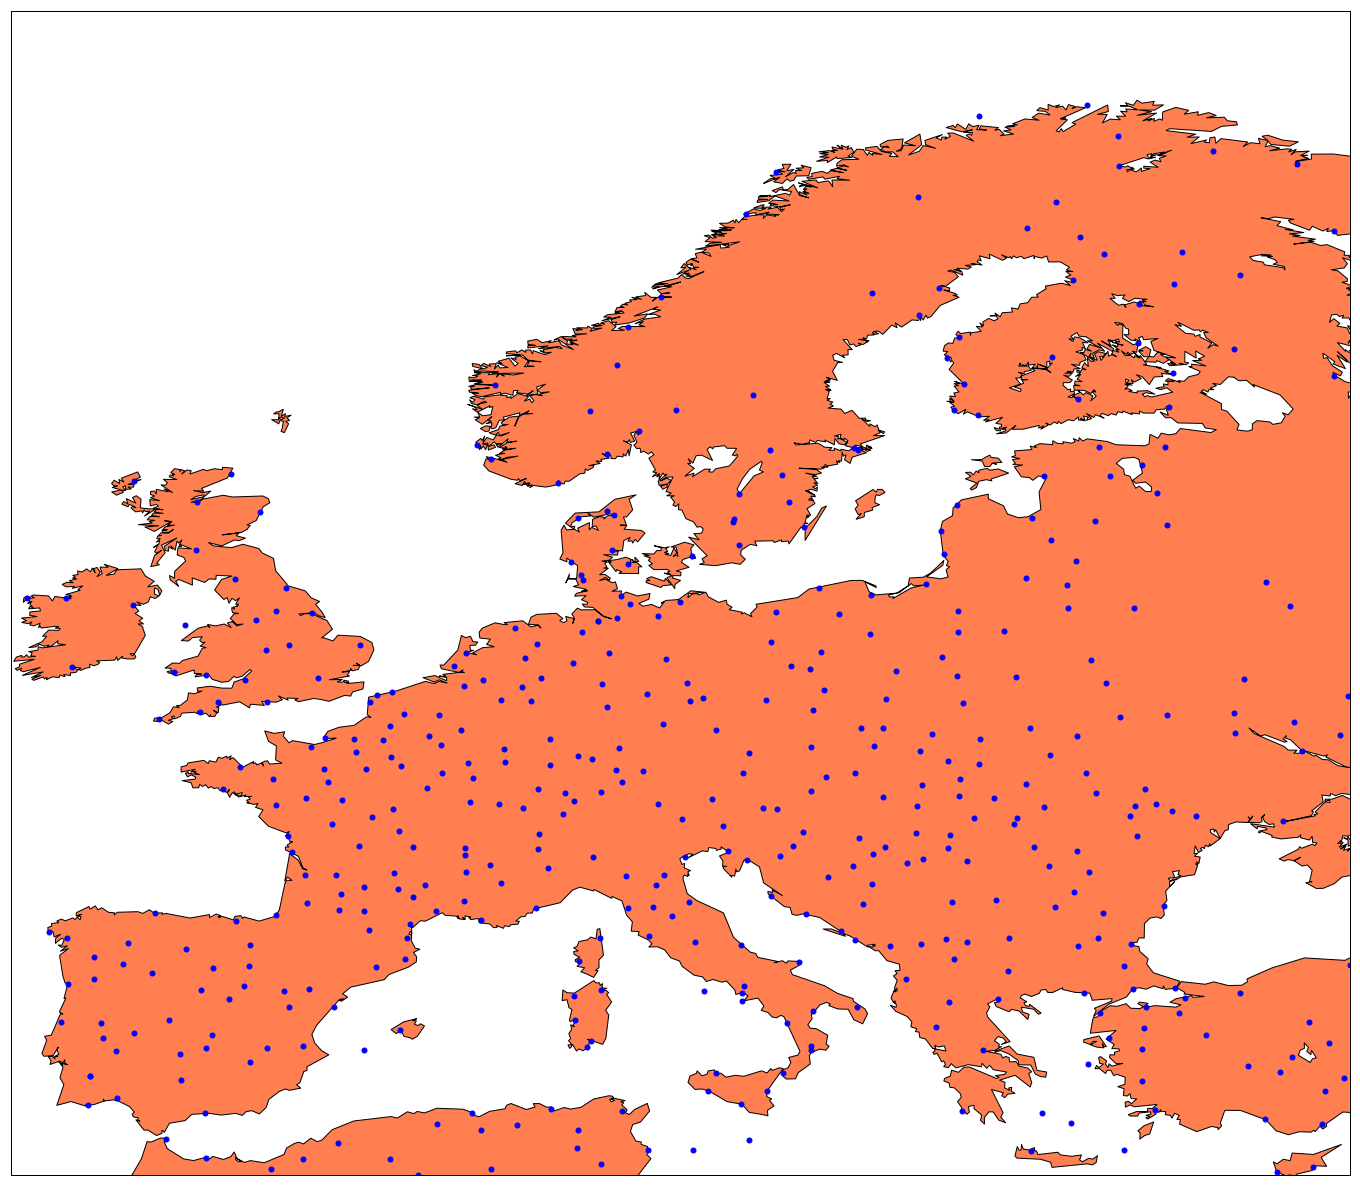

In [13]:
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=-10.56,llcrnrlat=34.65,urcrnrlon=34.88,urcrnrlat=74.17, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()
x, y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)



In [14]:
ids = []
for city in valid_cities:
    ids.append(city.get_ID())
    

In [15]:
ids

[2924585,
 2825297,
 2853969,
 2939797,
 2820256,
 2871992,
 2954172,
 2951825,
 2803560,
 2940132,
 2879139,
 2929670,
 2874545,
 2158777,
 2894003,
 2660123,
 2892518,
 2946447,
 2934246,
 2871845,
 2950158,
 2935517,
 2949186,
 2910831,
 2944387,
 2911298,
 2891122,
 2844588,
 3247449,
 2923822,
 359678,
 359796,
 360630,
 2167618,
 358619,
 1023365,
 352733,
 2467783,
 2464701,
 2468018,
 2465840,
 2473572,
 2464795,
 2473634,
 2270985,
 2508813,
 2476403,
 2498305,
 2505530,
 2507943,
 2497411,
 2489865,
 2500017,
 2503826,
 2490584,
 2481007,
 2491335,
 2483668,
 1261037,
 2481700,
 2501152,
 2502958,
 2505329,
 2506999,
 2519582,
 2549340,
 2542227,
 2555742,
 2553604,
 2542715,
 2538474,
 2529313,
 2558545,
 101628,
 250774,
 250441,
 294801,
 2210247,
 170654,
 1854585,
 616635,
 615532,
 610824,
 558118,
 483873,
 584243,
 571306,
 522377,
 582182,
 609965,
 2697944,
 485698,
 557413,
 466135,
 462522,
 561499,
 484907,
 545277,
 2510083,
 472757,
 526558,
 513042,
 562389,
 

In [16]:
observation_list = []
id20s = []
elt_id20 = []
c = 0
for c in range(0, len(ids)):
    elt_id20.append(ids[c])
    if len(elt_id20) == 20 or c == len(ids)-1:
        id20s.append(elt_id20)
        elt_id20 = []
    c = c + 1

for id20 in id20s:
    observation_list.append(owm.weather_at_ids(id20))
    time.sleep(1)


In [17]:
observation_list

[[<pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:59+00>,
  <pyowm.webapi25.observation.Observation - reception time=2018-12-01 20:45:

In [18]:
weathers = []
for obss in observation_list:
    for obs in obss:
        weathers.append(obs.get_weather())

In [19]:
weathers

[<pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=clouds, detailed status=few clouds>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=clear, detailed status=sky is clear>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=clear, detailed status=sky is clear>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=clouds, detailed status=broken clouds>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=clouds, detailed status=broken clouds>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=clear, detailed status=sky is clear>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=fog, detailed status=fog>,
 <pyowm.webapi25.weather.Weather - reference time=2018-12-01 20:45:59+00, status=rain, detailed status=very heavy rain>,
 <pyowm.webapi25.weather.Weather - reference time=2018

In [20]:
temps = []
for weather in weathers:
    temps.append(weather.get_temperature(unit='celsius'))

In [21]:
temps[0]['temp']

3.54

i_x = 0
i_x = 1
i_x = 2
i_x = 3
i_x = 4
i_x = 5
i_x = 6
i_x = 7
i_x = 8
i_x = 9
i_x = 10
i_x = 11
i_x = 12
i_x = 13
i_x = 14
i_x = 15
i_x = 16
i_x = 17
i_x = 18
i_x = 19
i_x = 20
i_x = 21
i_x = 22
i_x = 23
i_x = 24
i_x = 25
i_x = 26
i_x = 27
i_x = 28
i_x = 29
i_x = 30
i_x = 31
i_x = 32
i_x = 33
i_x = 34
i_x = 35
i_x = 36
i_x = 37
i_x = 38
i_x = 39
i_x = 40
i_x = 41
i_x = 42
i_x = 43
i_x = 44
i_x = 45
i_x = 46
i_x = 47
i_x = 48
i_x = 49
i_x = 50
i_x = 51
i_x = 52
i_x = 53
i_x = 54
i_x = 55
i_x = 56
i_x = 57
i_x = 58
i_x = 59
i_x = 60
i_x = 61
i_x = 62
i_x = 63
i_x = 64
i_x = 65
i_x = 66
i_x = 67
i_x = 68
i_x = 69
i_x = 70
i_x = 71
i_x = 72
i_x = 73
i_x = 74
i_x = 75
i_x = 76
i_x = 77
i_x = 78
i_x = 79
i_x = 80
i_x = 81
i_x = 82
i_x = 83
i_x = 84
i_x = 85
i_x = 86
i_x = 87
i_x = 88
i_x = 89
i_x = 90
i_x = 91
i_x = 92
i_x = 93
i_x = 94
i_x = 95
i_x = 96
i_x = 97
i_x = 98
i_x = 99
i_x = 100
i_x = 101
i_x = 102
i_x = 103
i_x = 104
i_x = 105
i_x = 106
i_x = 107
i_x = 108
i_x = 109
i_x = 110


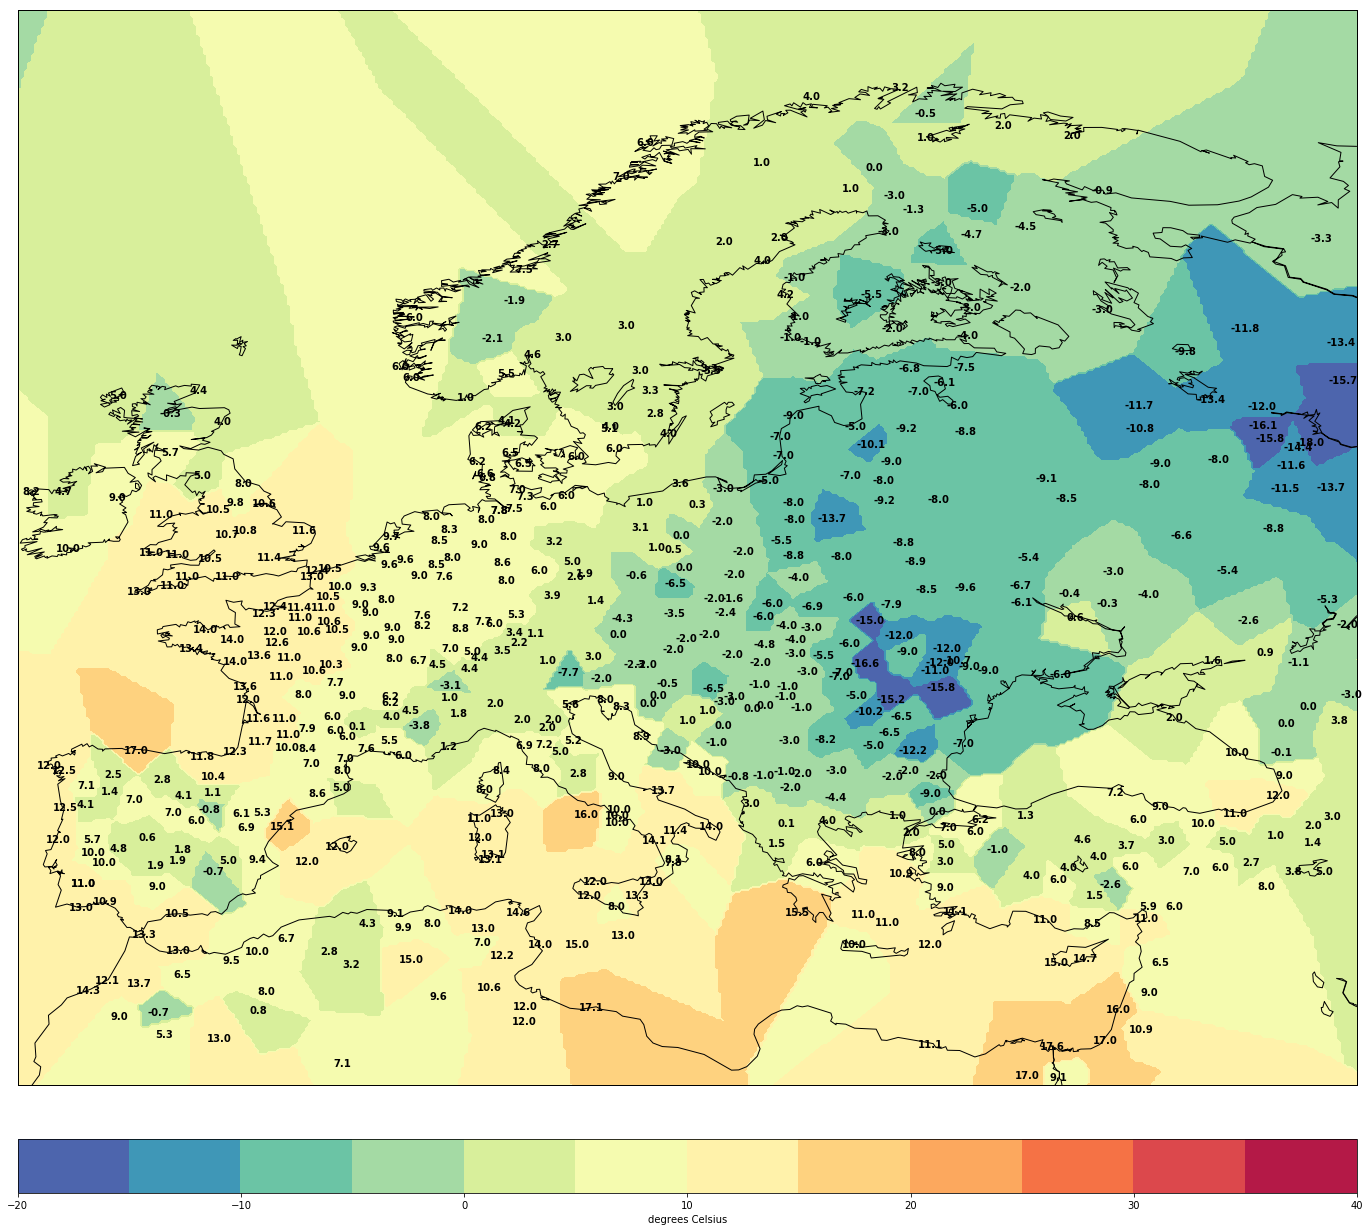

In [126]:
lon_min = -10.56
lat_min = 29.65
lon_max = 44.88
lat_max = 74.17

x_in_bounds = []
y_in_bounds = []
temps_in_bounds = []

plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()
x, y = map(lon, lat)
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]['temp']),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
        x_in_bounds.append(x[i])
        y_in_bounds.append(y[i])
        temps_in_bounds.append(temps[i]['temp'])

nx = 400
ny = 400
glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)

#Interpolation

#Dummy
data = np.zeros((nx, ny))

#Nearest neighbor with plane euclidian distance
for i_x in range(0, nx):
    print('i_x = %d' % i_x)
    for i_y in range(0, ny):
        distance_to_closest = 0
        idx_closest = -1
        distance = 0
        for it in range(0, len(lon)):
            distance = (glons[i_x][i_y]-lon[it])**2 + (glats[i_x][i_y]-lat[it])**2
            if (idx_closest < 0):
                distance_to_closest = distance
                idx_closest = it
            elif (distance_to_closest > distance):
                distance_to_closest = distance
                idx_closest = it
        data[i_x][i_y] = temps[idx_closest]['temp']

    
clevs = [-20,-15,-10,-5,0,5,10,15,20,25,30,35,40]
cs = map.contourf(gx,gy,data,clevs,cmap='Spectral_r')

cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')


In [120]:
glons[1]

array([-10.56000042, -10.        ,  -9.44000053,  -8.88000011,
        -8.32000065,  -7.76000023,  -7.20000029,  -6.64000034,
        -6.0800004 ,  -5.52000046,  -4.96000051,  -4.40000057,
        -3.84000015,  -3.28000021,  -2.72000027,  -2.1600008 ,
        -1.60000038,  -1.03999996,  -0.4800005 ,   0.07999992,
         0.63999939,   1.19999981,   1.75999928,   2.31999969,
         2.88000011,   3.43999958,   4.        ,   4.55999947,
         5.11999989,   5.67999935,   6.23999882,   6.80000019,
         7.35999966,   7.91999912,   8.4800005 ,   9.03999996,
         9.59999943,  10.15999889,  10.72000027,  11.27999973,
        11.8399992 ,  12.40000057,  12.96000004,  13.5199995 ,
        14.07999897,  14.64000034,  15.19999981,  15.75999928,
        16.31999969,  16.88000107,  17.43999863,  18.        ,
        18.56000137,  19.11999893,  19.68000031,  20.23999786,
        20.79999924,  21.36000061,  21.91999817,  22.47999954,
        23.0399971 ,  23.59999847,  24.15999985,  24.71

In [51]:
len(lat)

654

In [52]:
len(temps)

640

In [79]:
temps

[{'temp': 3.54, 'temp_kf': None, 'temp_max': 5.0, 'temp_min': 2.0},
 {'temp': 6.0, 'temp_kf': None, 'temp_max': 6.0, 'temp_min': 6.0},
 {'temp': 7.68, 'temp_kf': None, 'temp_max': 9.0, 'temp_min': 6.0},
 {'temp': 5.31, 'temp_kf': None, 'temp_max': 6.2, 'temp_min': 4.7},
 {'temp': 3.4, 'temp_kf': None, 'temp_max': 6.0, 'temp_min': 2.0},
 {'temp': 2.19, 'temp_kf': None, 'temp_max': 4.0, 'temp_min': 0.0},
 {'temp': 1.13, 'temp_kf': None, 'temp_max': 3.0, 'temp_min': 0.0},
 {'temp': 3.86, 'temp_kf': None, 'temp_max': 5.0, 'temp_min': 2.8},
 {'temp': 2.63, 'temp_kf': None, 'temp_max': 5.0, 'temp_min': 1.0},
 {'temp': 1.87, 'temp_kf': None, 'temp_max': 5.0, 'temp_min': 0.0},
 {'temp': 5.0, 'temp_kf': None, 'temp_max': 5.0, 'temp_min': 5.0},
 {'temp': 6.0, 'temp_kf': None, 'temp_max': 6.0, 'temp_min': 6.0},
 {'temp': 3.25, 'temp_kf': None, 'temp_max': 3.25, 'temp_min': 3.25},
 {'temp': 23.0, 'temp_kf': None, 'temp_max': 23.0, 'temp_min': 23.0},
 {'temp': 7.23, 'temp_kf': None, 'temp_max': 8.0

In [104]:
temps[46]

{'temp': 11.6, 'temp_kf': None, 'temp_max': 11.6, 'temp_min': 11.6}

In [ ]:
idx_closest